<a href="https://colab.research.google.com/github/jemurphyuk/fm_fragrance_review_data/blob/main/Freemavens_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing packages and data from source

In [1]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
import re

# from sklearn import metrics
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import MinMaxScaler

# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

In [3]:
start = time.time()
df = pd.read_excel('/content/drive/MyDrive/Task_Dataset.xlsx')
end = time.time()
print("Read excel: ",(end-start),"sec")


Read excel:  29.944846630096436 sec


# Data Manipulation and Cleanup

In [4]:
# To reset without reloading file ~30 seconds
fragrence_df = df


Output from df.info()
```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287298 entries, 0 to 287297
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   brand     287289 non-null  object
 1   product   287283 non-null  object
 2   date      287288 non-null  object
 3   review    287291 non-null  object
 4   rating    287294 non-null  object
dtypes: object(5)
memory usage: 11.0+ MB
```
Output from df.isna().sum()
```
brand        9
product     15
date        10
review       7
rating       4
dtype: int64
```


Output from df.nunique()
```
brand          143
product        496
date           140
review      130648
rating          10
dtype: int64
```

## List of data manipulation tasks
- Renaming of 'product ' column to 'product'

- NaN removal or filling
  - Convert np.nan string to df NaN
  - Drop NaN product rows
  - Brand derived from product where NaN
  - Median for ranking based on product
  - Median for dates based on product (decided not relevant so just dropped, given the small percentage of dates, 10 + 3 'nonsense' dates)
  - Drop empty dates and converted non date values
  - Fill NaN review with 'na'
- Universal naming for brands -> removal of multiple 'Valentino' to singular, case differences and spelling errors. This was achieved by looking at unique values
- Conversion of Ratings to float (where '3 out of 5 ' was a string, took the first digit, unique values to checked to ensure no other value other than a number occupied this string)
- Conversion of date column to date time and clean up of non datetime/number based dates

In [5]:
fragrence_df = df

# renaming of columns
fragrence_df = fragrence_df.rename(columns={'product ': 'product'})
column_list = fragrence_df.columns.tolist()

# NaN removal or filling
# - Convert all np.nan to df NaN
fragrence_df = fragrence_df.replace('np.nan', np.nan)

# Conversion of rating to int
fragrence_df['rating'] = np.where(fragrence_df['rating'].isna(), \
                                  fragrence_df['rating'], \
                                  fragrence_df['rating'].astype(str).str[0])
fragrence_df['rating'] = fragrence_df['rating'].astype(float)

# - Brand derived from product
# Had already checked to see if product and brand information was missing
# and would drop columns appropriately
fragrence_df['brand'] = fragrence_df['brand']\
                        .fillna(value=fragrence_df['product'].str.split().str[0])

# Universal brand naming
vals = {'Hugo': 'Hugo Boss', 'Huge Boss': 'Hugo Boss', 'mugler': 'Mugler'}
fragrence_df['brand'] = fragrence_df['brand'].replace(vals)
fragrence_df['brand'] = fragrence_df['brand']\
                        .replace(regex=r'\s*Valentino.*', value='Valentino')

# Drop NaN product information for ratings
fragrence_df = fragrence_df.dropna(subset=['product'])

# - Median for ranking based on product
fragrence_df['rating'] = fragrence_df.groupby(['product'])['rating']\
                        .transform(lambda x: x.fillna(x.median()))

# Conversion of date column to date time, clean up of non datetime/number
# based dates AND drop empty dates and converted non date values
fragrence_df['date'] = fragrence_df['date']\
                      .replace(to_replace=r'^\w+$', value=np.nan, regex=True)\
                      .replace(17, np.nan)
fragrence_df = fragrence_df.dropna(subset=['date'])
fragrence_df['date'] = fragrence_df['date']\
                      .apply(lambda x: x.strftime('%Y%m%d') \
                      if type(x) is datetime.datetime else str(x))
fragrence_df['date'] = pd.to_datetime(fragrence_df['date'], format="%m%d%Y", \
                                      errors="coerce")\
                                      .fillna(pd.to_datetime\
                                       (fragrence_df['date'], \
                                        format="%Y%m%d", errors="coerce"))

# - Fill review with 'na'
fragrence_df['review'] = fragrence_df['review'].fillna(value='na')

# - Creation of volume column from product
fragrence_df['volume'] = fragrence_df['product']\
                      .str.extract(r'(\d+[mM])')
# Those with no mL have an m at least, also those with no number reference
# 'Sample' indicating a small volume such as 5
fragrence_df['volume'] = fragrence_df['volume'].fillna('5')\
                          .str.rstrip('mM').astype(int)

# - Generation of 'is_promotion' column based on review section
promotion_regex = r'(\[This review was collected as part of a promotion\.])'
promotion_string = '[This review was collected as part of a promotion.]'
promotion_map = {promotion_string: 1, 'no': 0}
fragrence_df['is_promotion'] = fragrence_df['review'].str.extract(promotion_regex)
fragrence_df['is_promotion'] = fragrence_df['is_promotion'].fillna('no')\
                                .map(promotion_map)

## Numbers before and after cleanup
Total rows
 - Before = 287298
 - After = 287269
 - Dropped = 29

## Testing code blocks

In [ ]:
# renaming of 'product ' column to 'product'
fragrence_df = fragrence_df.rename(columns={'product ': 'product'})
column_list = fragrence_df.columns.tolist()
print(column_list)

['brand', 'product', 'date', 'review', 'rating', 'volume', 'is_promotion']


In [ ]:
fragrence_df.head()

,brand,product,date,review,rating,volume,is_promotion
0,Mugler,Mugler Alien Goddess Eau de Parfum Refill Bott...,2021-10-05,[This review was collected as part of a promot...,5.0,100,1
1,Valentino,Valentino Voce Viva Eau de Parfum Spray 50ml,2021-03-24,[This review was collected as part of a promot...,5.0,50,1
2,Lancome,Lancome Idôle L'Intense Eau de Parfum 25ml,2020-11-25,Lancôme la Vie Est Belle is my ultimate favour...,5.0,25,0
3,Lancome,Lancome Idôle L'Intense Eau de Parfum 25ml,2020-11-25,Love the light yet strong floral fragrance of ...,5.0,25,0
4,Lancome,Lancome Idôle L'Intense Eau de Parfum 25ml,2020-11-25,"Very nice and long lasting, i would recommend it.",5.0,25,0


In [ ]:
unique_rating = fragrence_df['rating'].unique()
unique_product = fragrence_df['product'].unique()
unique_brand = fragrence_df['brand'].unique()
unique_date = fragrence_df['date'].unique()
print(unique_rating
      # , unique_product
      # , unique_brand
      , unique_date
      )

[5. 4. 2. 3. 1.] ['2021-10-05T00:00:00.000000000' '2021-03-24T00:00:00.000000000'
 '2020-11-25T00:00:00.000000000' '2021-05-24T00:00:00.000000000'
 '2021-09-30T00:00:00.000000000' '2021-10-20T00:00:00.000000000'
 '2021-08-22T00:00:00.000000000' '2021-07-23T00:00:00.000000000'
 '2021-06-23T00:00:00.000000000' '2021-04-24T00:00:00.000000000'
 '2021-03-25T00:00:00.000000000' '2021-02-23T00:00:00.000000000'
 '2021-12-04T00:00:00.000000000' '2020-12-25T00:00:00.000000000'
 '2021-10-19T00:00:00.000000000' '2021-10-18T00:00:00.000000000'
 '2021-10-17T00:00:00.000000000' '2021-10-16T00:00:00.000000000'
 '2021-10-15T00:00:00.000000000' '2021-10-13T00:00:00.000000000'
 '2021-10-12T00:00:00.000000000' '2021-10-11T00:00:00.000000000'
 '2021-10-10T00:00:00.000000000' '2021-10-09T00:00:00.000000000'
 '2021-10-08T00:00:00.000000000' '2021-10-07T00:00:00.000000000'
 '2021-10-06T00:00:00.000000000' '2021-10-04T00:00:00.000000000'
 '2021-10-03T00:00:00.000000000' '2021-10-02T00:00:00.000000000'
 '2021-1

In [ ]:
fragrence_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287269 entries, 0 to 287297
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   brand         287269 non-null  object        
 1   product       287269 non-null  object        
 2   date          287269 non-null  datetime64[ns]
 3   review        287269 non-null  object        
 4   rating        287269 non-null  float64       
 5   volume        287269 non-null  int64         
 6   is_promotion  287269 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 17.5+ MB


In [ ]:
# sum of NaNs in each column
fragrence_df.isna().sum()

brand           0
product         0
date            0
review          0
rating          0
volume          0
is_promotion    0
dtype: int64

In [ ]:
fragrence_df.nunique()

brand               11
product            495
date                69
review          130646
rating               5
volume              19
is_promotion         2
dtype: int64

In [ ]:
# a print out of a review with the prefix
# '[This review was collected as part of a promotion.]'
fragrence_df['review'][1]

'[This review was collected as part of a promotion.] This scent is gorgeous, not too strong yet not too weak, would deffo recommended to my friends and family, when shopping someone said I smelt lovely x'

In [ ]:
fragrence_df[fragrence_df.eq(datetime.datetime(2020, 11, 23, 0, 0)).any(axis=1)]

,brand,product,date,review,rating,volume,is_promotion
48190,Calvin Klein,Calvin Klein Eternity Eau de Parfum Spray 30ml,2020-11-23,Spray on your hair for longer lasting fragranc...,5.0,30,0
48191,Calvin Klein,Calvin Klein Eternity Eau de Parfum Spray 30ml,2020-11-23,great for everyday use,5.0,30,0
48192,Calvin Klein,Calvin Klein Eternity Eau de Parfum Spray 30ml,2020-11-23,"nice fresh scent,but spray thinly or will be o...",4.0,30,0
48193,Calvin Klein,Calvin Klein Eternity Eau de Parfum Spray 30ml,2020-11-23,I use this project regularly.,5.0,30,0
48194,Calvin Klein,Calvin Klein Eternity Eau de Parfum Spray 30ml,2020-11-23,This is a lovely inexpensive every day perfume.,5.0,30,0
...,...,...,...,...,...,...,...
54787,Hugo Boss,HUGO Woman Eau de Parfum Spray 50ml,2020-11-23,What a fantastic price for a favourite eau de ...,5.0,50,0
54788,Hugo Boss,HUGO Woman Eau de Parfum Spray 50ml,2020-11-23,Bought this perfume in November and reorder it...,4.0,50,0
54789,Hugo Boss,HUGO Woman Eau de Parfum Spray 50ml,2020-11-23,I had this for Christmas. It’s such a unique s...,5.0,50,0
54790,Hugo Boss,HUGO Woman Eau de Parfum Spray 50ml,2020-11-23,I bought this as a Christmas present for my si...,5.0,50,0


In [ ]:
fragrence_df[fragrence_df['review'] == 'na']

,brand,product,date,review,rating,volume,is_promotion
21272,Hugo Boss,Hugo Boss Bottled Eau de Parfum 50ml,2020-11-26,na,5.0,50,0
21273,Hugo Boss,Hugo Boss Bottled Eau de Parfum 50ml,2020-11-26,na,5.0,50,0
21274,Hugo Boss,Hugo Boss Bottled Eau de Parfum 50ml,2020-11-26,na,5.0,50,0
48578,Calvin Klein,Calvin Klein CK Be Eau de Toilette Spray 100ml,2020-11-23,na,5.0,100,0
49436,Calvin Klein,Calvin Klein Euphoria Men Eau de Toilette Spra...,2020-11-23,na,5.0,50,0
170820,Valentino,Valentino Voce Viva Eau de Parfum Spray 50ml,2021-03-24,na,5.0,50,0
170824,Valentino,Valentino Voce Viva Eau de Parfum Spray 50ml,2021-03-24,na,5.0,50,0
170830,Valentino,Valentino Voce Viva Eau de Parfum Spray 50ml,2021-03-24,na,3.0,50,0
244834,YSL,YSL Cinema Eau de Parfum Spray 90ml,2020-12-24,na,5.0,90,0


In [ ]:
search_col = 'volume'
fragrence_df[fragrence_df[search_col] == 118]

,brand,product,date,review,rating,volume,is_promotion
151474,Ralph Lauren,Ralph Lauren Polo Green Cologne Intense EDT Sp...,2021-08-21,Excellent product and service. Many thanks onc...,5.0,118,0
151475,Ralph Lauren,Ralph Lauren Polo Green Cologne Intense EDT Sp...,2021-07-22,Great new smell and even more happy with a fre...,5.0,118,0
151476,Ralph Lauren,Ralph Lauren Polo Green Cologne Intense EDT Sp...,2021-07-22,Bought as a gift. Husband delighted with it. I...,5.0,118,0
151477,Ralph Lauren,Ralph Lauren Polo Green Cologne Intense EDT Sp...,2021-07-22,[This review was collected as part of a promot...,5.0,118,1
151478,Ralph Lauren,Ralph Lauren Polo Green Cologne Intense EDT Sp...,2021-06-22,[This review was collected as part of a promot...,5.0,118,1
...,...,...,...,...,...,...,...
151537,Ralph Lauren,Ralph Lauren Polo Green Cologne Intense EDT Sp...,2021-05-23,[This review was collected as part of a promot...,5.0,118,1
151538,Ralph Lauren,Ralph Lauren Polo Green Cologne Intense EDT Sp...,2021-05-23,[This review was collected as part of a promot...,4.0,118,1
151539,Ralph Lauren,Ralph Lauren Polo Green Cologne Intense EDT Sp...,2021-05-23,[This review was collected as part of a promot...,5.0,118,1
151540,Ralph Lauren,Ralph Lauren Polo Green Cologne Intense EDT Sp...,2021-05-23,[This review was collected as part of a promot...,5.0,118,1


## Singular variable test

In [ ]:
fragrence_df[(fragrence_df['brand'] == 'Lancome')\
             & (fragrence_df['review'].str.contains('free', regex=False) == True)]

# Data analysis and graphs

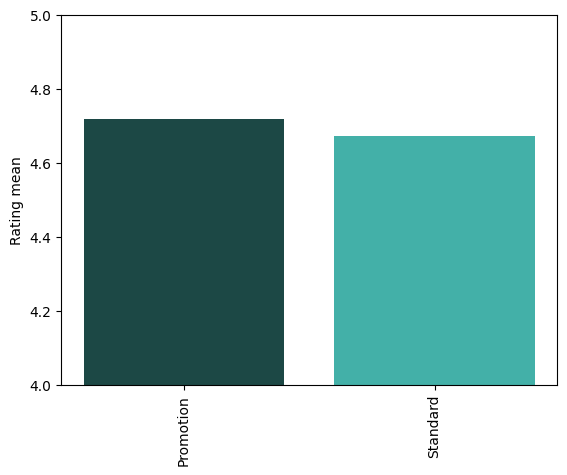

rating        
                  mean   count
is_promotion                  
1             4.718070  184159
0             4.673611  103110

In [ ]:
x = ['Promotion', 'Standard']
y = [4.718070, 4.673611]

fig, ax = plt.subplots()
ax.bar(x, y, label=x, color=['#1C4845', '#43B0A8'])
ax.set_ylabel('Rating mean')
plt.ylim(4, 5)
plt.xticks(rotation=90)
plt.show()

fragrence_df.groupby('is_promotion').agg({'rating': ['mean', 'count'] \
                                  #  , 'date': ['mean', 'median']\
                                          })\
                              .sort_values(('rating', 'mean'), ascending=False)

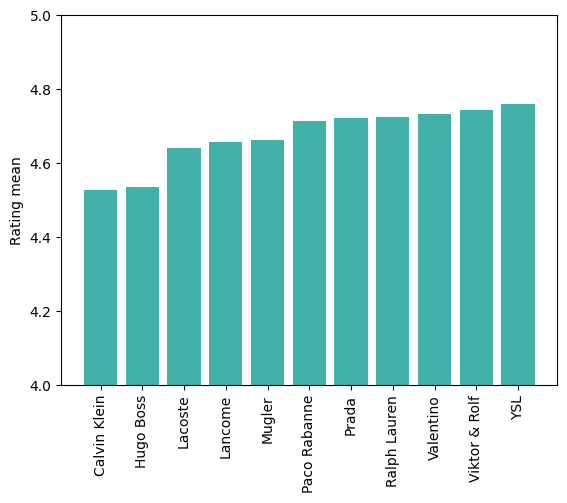

In [ ]:
# Mean ratings ranked by brand
brand_df = fragrence_df.groupby('brand').agg({'rating': ['mean']})\
          .sort_values('brand', ascending=True)

x = list(brand_df.index)
y = [4.536551, 4.527798, 4.641766, 4.726136, 4.657265, 4.714854, 4.733917, 4.663717, 4.720999, 4.743714, 4.759836]
y = sorted(y, key=float)

fig, ax = plt.subplots()
ax.bar(x, y, label=x, color='#43B0A8')
ax.set_ylabel('Rating mean')
plt.ylim(4, 5)
plt.xticks(rotation=90)
plt.show()

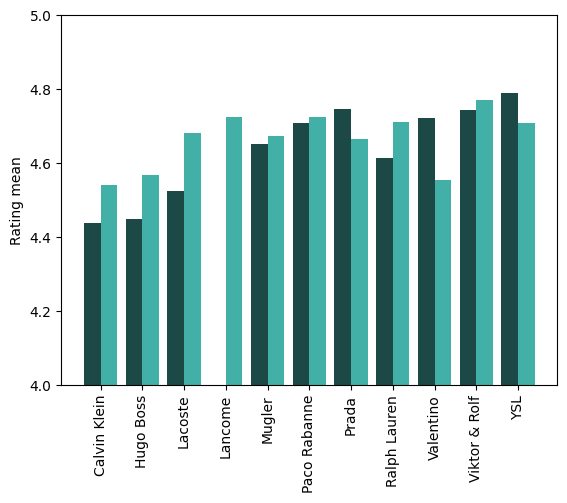

In [ ]:
brand_prom_mean = fragrence_df.groupby(['brand', 'is_promotion'])\
            .agg({'rating': ['mean']})
brand_prom_mean.columns = brand_prom_mean.columns.droplevel()
brand_prom_mean = brand_prom_mean.reset_index()


x = brand_prom_mean.brand.unique()
y1 = list(brand_prom_mean['mean'][brand_prom_mean['is_promotion'] == 0])
y2 = list(brand_prom_mean['mean'][brand_prom_mean['is_promotion'] == 1])
y2.insert(3, 0.0)
width = 0.40

fig, ax = plt.subplots()
ax.set_ylabel('Rating mean')
plt.bar(x, y1, width=0.4, color='#43B0A8', align='edge')
plt.bar(x, y2, width=-0.4, color='#1C4845', align='edge')
plt.ylim(4, 5)
plt.xticks(rotation=90)
plt.show()


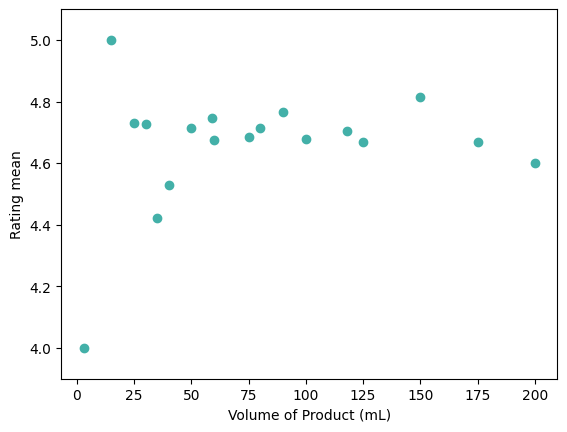

In [ ]:
volume_df = fragrence_df.groupby('volume').agg({
                                  'rating': ['mean', 'median', 'count'] \
                                , 'date': ['mean', 'median', 'count'] \
                                   })\
                              .sort_values(('rating', 'mean'), ascending=False)
volume_df = volume_df.reset_index()

x = volume_df['volume']
y = volume_df['rating']['mean']
fig, ax = plt.subplots()
ax.set_xlabel('Volume of Product (mL)')
ax.set_ylabel('Rating mean')
plt.scatter(x,y, color='#43B0A8')
plt.ylim(3.9, 5.1)
plt.show()


In [11]:
# Table showing the number of reviews for each day and propotion of promotional
# reviews. The graph has been hashed out due to it not being
# particularly aesthetic

def promotion_mean(x):
  return x.mean()

all_date_count = fragrence_df.groupby(['date'], as_index=False)\
            .agg({'rating': ['mean', 'count'], 'is_promotion': [promotion_mean]})\
            .sort_values(('date', ''), ascending=True)
all_date_count.columns = all_date_count.columns.droplevel()
all_date_count = all_date_count.rename(columns={'': 'date', 'mean': 'rating_mean'})
upper_outlier_limit = 1.5 * (all_date_count['count'].quantile(q=0.75)\
                       - all_date_count['count'].quantile(q=0.25))
print(upper_outlier_limit)
all_date_count[all_date_count['count'] > (upper_outlier_limit + \
                                          all_date_count['count'].quantile(q=0.75))]\
                                           # this is a df of outliers

# fig, ax1 = plt.subplots()

# color = 'tab:red'
# ax1.set_xlabel('date')
# ax1.set_ylabel('count', color=color)
# ax1.plot(all_date_count['date'], all_date_count['count'], color=color)
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('mean', color=color)  # we already handled the x-label with ax1
# ax2.plot(all_date_count['date'], all_date_count['mean'], color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()

4159.5


,date,rating_mean,count,promotion_mean
1,2020-11-24,4.728853,115369,0.622559
3,2020-11-26,4.546429,13720,0.000000
5,2020-12-24,4.731506,13464,0.812463
11,2021-02-22,4.645695,14496,0.975373
15,2021-03-24,4.737615,21861,0.972417
23,2021-05-23,4.743405,12245,0.983503
27,2021-06-22,4.718001,8805,0.961953
35,2021-08-21,4.722761,9692,0.919315
48,2021-10-05,4.707491,7863,0.989953
62,2021-10-19,4.709792,11795,0.965918


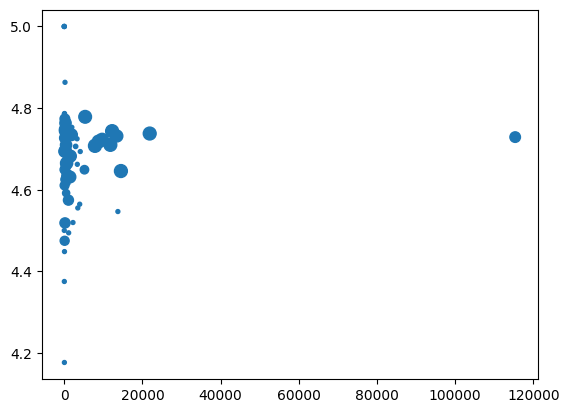

In [ ]:
# This graph shows the count of each day of ratings against rating.
# The size of each bubble is proportional to how many promotional reviews
# formed part of that day

x = all_date_count['count']
y = all_date_count['rating_mean']
a, b = np.polyfit(x, y, 1)
area = (0.1 + all_date_count['promotion_mean']) * 80
plt.scatter(x,y, s=area)
plt.show()

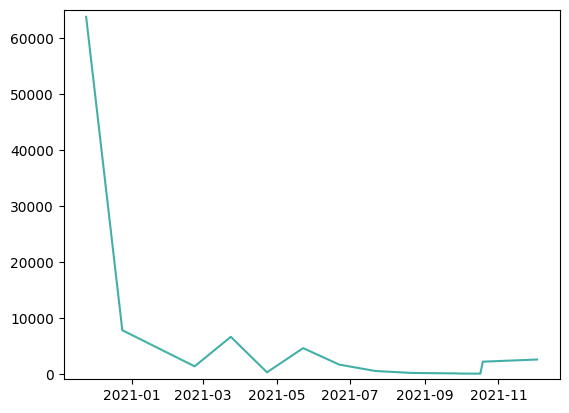

,date,mean,count
0,2020-11-24,4.754986,63723
1,2020-12-24,4.726875,7762
2,2021-02-22,4.811306,1309
3,2021-03-24,4.823485,6583
4,2021-04-23,4.751037,241
5,2021-05-23,4.725060,4561
6,2021-06-22,4.775713,1614
7,2021-07-22,4.682773,476
8,2021-08-21,4.753731,134
9,2021-09-25,4.755102,49


In [ ]:
# This graph shows the YSL review count for each day in the data set

YSL_date_df = fragrence_df[fragrence_df['brand'] == 'YSL'].groupby(['date'], as_index=False)\
            .agg({'rating': ['mean', 'count']})\
            .sort_values(('date', ''), ascending=True)
YSL_date_df.columns = YSL_date_df.columns.droplevel()
YSL_date_df = YSL_date_df.rename(columns={'': 'date'})

x = YSL_date_df['date']
y = YSL_date_df['count']
plt.plot(x, y, color='#43B0A8')
plt.ylim(-1000, 65000)
plt.show()
YSL_date_df